# Pros of adding details

author: laquitainesteeve@gmail.com

Execution time:

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz) with RTX 5090 GPU with 40GB VRAM

Prerequisites:
- 13 GB of storage for 1500 templates
- kilosort4 sorting extractors

Descriptions:

- Original Buccino simulation: 
    - 250 neurons: 
    - neuron locations cannot be closer than the min_dist parameter (default 25)
    - no cell metadata

TODO:
- upload the recordings and sorting extractors to dandi archive (if possible)

RESULTS:

- The low yield in our biophy. validated model is not explained by: 
    - the cell count and density per synaptic cell type
    - the low firing rate
    - the waveform length (Buccino is based on the same BBP's cell models)

Methods:
- We simulated one intermediate dataset with the same cell counts as npx_spont (100GB, 78 min). Because yield did not decrease to match npx_spont, but rather increased we simulated lower cell counts, we hereafter simulate a lower cell counts with the same exc/inh ratio (25GB, 23) for its efficiency. 10 simulations require take 1 TB storage! This setup is much faster to sort (10 min max)

- Buccino's model overhang: 30 (default) # extension in un beyond MEA boundaries for neuron locations (if lim is null)

- firing_range: no max_rate parameters so we matched min_rate, and firing exc and inh stds and check the resulting max_rate

## Setup 

Activate mearec virtual environment

In [11]:
%%time
%load_ext autoreload
%autoreload 2

# import packages
import os 
import MEArec as mr
import numpy as np
import spikeinterface.extractors as se 
import spikeinterface.sorters as sorters 
import spikeinterface.comparison as sc  
from matplotlib import pyplot as plt;
import spikeinterface as si
from spikeinterface.curation import remove_excess_spikes
from spikeinterface import extract_waveforms
import spikeinterface.qualitymetrics as sqm
import spikeinterface.core.template_tools as ttools
from numpy.linalg import norm as lalgnorm
import warnings
from scipy.spatial.distance import cdist
warnings.filterwarnings('ignore')

# SET PROJECT PATH

PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(PROJ_PATH)

# import custom package
from src.nodes.validation import firing_rate as fr
from src.nodes.analysis.failures import isolation

# parameters
DURATION_S = 600 # duration of recording period considered in seconds

# SET DATA PATHS

# original buccino simulation
RECORDING_BUCCINO_PATH = 'dataset/01_intermediate/preprocessing/recording_buccino/'
GROUND_TRUTH_BUCCINO_PATH = 'dataset/00_raw/ground_truth_buccino/'
WAVEFORM_GT_BUCCINO_PATH =  './temp/pros_of_details/waveformextractor_buccino/'

# setup simulation common template parameters
DATA_PATH = './temp/pros_of_details/'
CELLS_PATH = mr.get_default_cell_models_folder()

# parameter Buccino copy
TEMPLATES_PATH = './temp/pros_of_details/templates.h5' # warning initially was not 1500 templates but much less 200 - check if that has an effect
RECORDING_CLONE_H5_PATH = './temp/pros_of_details/recordings.h5'
RECORDING_CLONE_PATH = 'dataset/00_raw/recording_buccino_clone/'
GROUND_TRUTH_CLONE_PATH = 'dataset/00_raw/ground_truth_buccino_clone/'
WAVEFORM_GT_CLONE_PATH =  './temp/pros_of_details/waveformextractor_buccino_clone/'

# parameters synthetic 2
RECORDING_S2_H5_PATH = './temp/pros_of_details/recordings_s2.h5'
RECORDING_S2_PATH = 'dataset/00_raw/recording_buccino_s2/'
GROUND_TRUTH_S2_PATH = 'dataset/00_raw/ground_truth_buccino_s2/'
WAVEFORM_GT_S2_PATH =  './temp/pros_of_details/waveformextractor_buccino_s2/'

# parameters synthetic 3
RECORDING_S3_H5_PATH = './temp/pros_of_details/recordings_s3.h5'
RECORDING_S3_PATH = 'dataset/00_raw/recording_buccino_s3/'
GROUND_TRUTH_S3_PATH = 'dataset/00_raw/ground_truth_buccino_s3/'
WAVEFORM_GT_S3_PATH =  './temp/pros_of_details/waveformextractor_buccino_s3/'

# parameters synthetic 4
RECORDING_S4_H5_PATH = './temp/pros_of_details/recordings_s4.h5'
RECORDING_S4_PATH = 'dataset/00_raw/recording_buccino_s4/'
GROUND_TRUTH_S4_PATH = 'dataset/00_raw/ground_truth_buccino_s4/'
WAVEFORM_GT_S4_PATH =  './temp/pros_of_details/waveformextractor_buccino_s4/'

# npx_spont
RECORDING_NS_PATH = 'dataset/01_intermediate/preprocessing/recording_npx_spont/'
GROUND_TRUTH_NS_PATH = 'dataset/00_raw/ground_truth_npx_spont/'
WAVEFORM_GT_NS_PATH = 'dataset/01_intermediate/waveforms/ground_truth_npx_spont/'
SORTING_KS4_NS_PATH = 'dataset/01_intermediate/sorting/npx_spont/SortingKS4_10m'

# parallel processing parameters
N_JOBS = 20
CHUNKS = 50000

# parallel processing parameters 
job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)
savefig_cfg = {"transparent":True, "dpi": 300}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 1.44 ms, sys: 0 ns, total: 1.44 ms
Wall time: 4.21 ms


## Custom functions

In [2]:
# UTILS 

def _euclidean_distance(coord_1, coord_2):
    return np.sqrt(np.sum((coord_1 - coord_2) ** 2))


def mad(data):
    mean_data = np.mean(data)
    return np.mean(np.absolute(data - mean_data))


def get_mad_ratio(spike_amp, noise_amp):
    """calculate an sd_ratio robust to outliers

    Args:
        spike_amp (_type_): _description_
        noise_amp (_type_): _description_

    Returns:
        _type_: _description_
    """
    mad_unit = mad(spike_amp)  # twice smaller than std
    mad_noise = mad(noise_amp)
    return mad_unit / mad_noise


def get_best_site_mad_noise(we, max_chids, unit):

    # get waveforms
    wv, _ = we.get_waveforms(unit_id=unit, with_index=True)

    # get channel ids (sparse)
    c_ids = we.sparsity.unit_id_to_channel_ids[unit]

    # get nearest channel
    max_chid = max_chids[unit]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    return wv[:, :, max_chid_ix].flatten()


def get_waveform_amplitudes_per_unit(We):
    return si.postprocessing.compute_spike_amplitudes(We, peak_sign="neg", outputs="by_unit")[0]


def get_cell_to_cell_distances(GroundTruth):
   
    x = GroundTruth.get_property('x')
    y = GroundTruth.get_property('y')
    z = GroundTruth.get_property('z')
    cell_pos = np.array([x, y, z]).T
    return cdist(cell_pos, cell_pos, metric='euclidean')


# SIMULATE SYNTHETIC RECORDING WITH MEAREC

def simulate_synthetic_recording_with_mearec(rec_prms: dict, layer:str, templates_path, recording_clone_h5_path, recording_clone_path, sorting_gt_clone_path, n_jobs, chunks):

    # generate simulated recording (takes 22 min)
    rec_gen = mr.gen_recordings(params=rec_prms, templates=templates_path)

    # save simulated recording
    mr.save_recording_generator(rec_gen, recording_clone_h5_path)

    # load recording h5 file
    RecordingClone = se.MEArecRecordingExtractor(recording_clone_h5_path) 
    RecordingClone.set_property("layers", np.array([layer]*384)) # add layer metadata

    # load ground truth
    SortingClone = se.MEArecSortingExtractor(recording_clone_h5_path)

    # save recording extractors
    RecordingClone.save(folder=recording_clone_path, n_jobs=n_jobs, 
                verbose=True, progress_bar=True, overwrite=True, 
                dtype="float32", chunk_size=chunks)
    
    # save sorting extractors
    SortingClone.save(folder=sorting_gt_clone_path, overwrite=True)

    # delete intermediate h5 file
    os.remove(recording_clone_h5_path)
    return RecordingClone, SortingClone, rec_gen


def report_simulation_parameters(rec_gen):
    """
    Reports simulation parameters, checks for bursting, and displays example cell metadata.

    Args:
        rec_gen (RecordingGenerator): The recording generator object.
    """
    # report parameters
    display('Simulation parameters:', rec_gen.info)

    # check bursting
    bursting = []
    for ix in range(250):
        bursting.append(rec_gen.spiketrains[1].annotations['bursting'])
    print('Bursting:', any(bursting))

    # example of a cell metadata
    CELL_IDX = 0
    print('\nExample cell type:', rec_gen.template_celltypes[CELL_IDX])
    display('Its spiking metadata:', rec_gen.spiketrains[CELL_IDX].annotations)
    print('Its spike times:', rec_gen.spiketrains[CELL_IDX].times)


def get_cell_type_property_from_mearec(simulation):
    cell_types = []
    for ix in range(len(simulation.spiketrains)):
        cell_types.append(simulation.spiketrains[ix].annotations['cell_type'])
    return np.array(cell_types)


# QUALITY METRICS FOR A SINGLE UNIT

def get_spatial_spread(
    We, unit_id: int, max_chids: dict, channel_ids, channel_coord
):
    """measure unit's spatial spread

    Args:
        unit_id (int): _description_
        max_chids (dict): _description_
        Recording (_type_): _description_
        channel_ids (_type_): _description_
        channel_coord (_type_): _description_

    Returns:
        _type_: _description_
    """
    # get waveforms
    wv, _ = We.get_waveforms(unit_id=unit_id, with_index=True)    

    # get the site ids (sparse)
    c_ids = We.sparsity.unit_id_to_channel_ids[unit_id]

    # get the nearest site
    max_chid = max_chids[unit_id]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    
    # get the average spike on each site
    mean_spikes = wv.mean(axis=0)
    max_spike = mean_spikes[:, max_chid_ix]
    
    # measure the average spike's similarity 
    # of each site to the average spike
    # of the nearest site to the unit
    # (ratio between 0 and 1)
    n_sites = mean_spikes.shape[1]
    cosim_weights = []
    for s_i in range(n_sites):
        cosim_weights.append(
            np.dot(max_spike, mean_spikes[:, s_i])
            / (lalgnorm(max_spike) * lalgnorm(mean_spikes[:, s_i]))
        )
    cosim_weights = np.array(cosim_weights)

    # threshold the similarity metric to be positive
    # we only look at similarity (not inverse similarity (<0))
    cosim_weights[cosim_weights < 0] = 0

    # measure the distance of the site to the nearest site
    # to the unit
    channel_coord = channel_coord[np.isin(channel_ids, c_ids), :]
    try:
        max_chids_coord = channel_coord[max_chid_ix, :]
    except:
        from ipdb import set_trace; set_trace()
        
    dist = []
    for ix, _ in enumerate(c_ids):
        dist.append(_euclidean_distance(max_chids_coord, channel_coord[ix]))
    dist = np.array(dist)

    # return spatial spread
    return {
        "spatial_spread": np.dot(cosim_weights, dist),
        "channel_distance": dist,
        "weights": cosim_weights,
    }


# QUALITY METRICS / SPIKE FEATURES FOR ALL UNITS

def get_firing_rates(sorting, duration_s):
    """
    Plots the firing rate distribution of units in a sorting extractor.

    Parameters:
    - sorting: spikeinterface SortingExtractor
        The sorting extractor containing spike trains.
    - duration_s: the total duration
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    unit_ids = sorting.get_unit_ids()
    firing_rates = [
        len(sorting.get_unit_spike_train(unit_id)) / duration_s
        for unit_id in unit_ids
    ]
    return firing_rates


def get_firing_ranges(waveform_extractor):

    firing_range = sqm.compute_firing_ranges(waveform_extractor=waveform_extractor)
    return np.array(list(firing_range.values()))


def get_waveform_amplitude_medians(waveform_extractor):

    amplitude_medians = sqm.compute_amplitude_medians(waveform_extractor=waveform_extractor)
    return np.array(list(amplitude_medians.values()))


def get_waveform_snr(waveform_extractor):
    snrs = sqm.compute_snrs(waveform_extractor=waveform_extractor)
    return np.array(list(snrs.values()))


def get_spatial_spread_all_units(
    recording_path: str, study_path: str, ms_before=3, ms_after=3, peak_sign="neg"
):
    """get all units' spatial extent metrics

    Args:
        recording_path (str): Path of the Recording Extractor
        study_path (str): _description_
        ms_before (float): _description_
        ms_after (float): _description_

    Returns:
        (dict): spatial spread of each unit
        - key: true unit id
        - value: spatial spread
    
    Prerequisites:
        - have extracted ground truth waveforms
    """
    # takes 1:30 min
    We = si.WaveformExtractor.load_from_folder(study_path)
    
    # get sites' distance to the max site
    # get 3D coordinates
    Rec = si.load_extractor(recording_path)
    channel_coord = Rec.get_probe().contact_positions
    channel_ids = Rec.get_channel_ids()

    # get channels where spike amplitude is maximal
    max_chids = ttools.get_template_extremum_channel(
        We, peak_sign=peak_sign)

    # takes 1:30 min (1310 units)
    spatial_spread = dict()
    for _, unit in enumerate(We.unit_ids):
        spatial_spread[unit] = get_spatial_spread(
            We, unit, max_chids, channel_ids, channel_coord
        )["spatial_spread"]
    return np.array(list(spatial_spread.values()))


def get_mad_ratios(WeOriginal):
    """get mad ratio per unit. Values close to 1 indicate a good isolation of the unit.
    i.e., the mean absolute deviation of the spike amplitude is similar to the mean absolute deviation 
    of the noise amplitude.

    Args:
        WeOriginal (WaveformExtractor): _description_

    Returns:
        np.array: mad ratio per unit
    """
    # pre-compute negative spike amplitudes
    amplitudes_by_unit = get_waveform_amplitudes_per_unit(WeOriginal)

    # get nearest channels
    max_chids = ttools.get_template_extremum_channel(WeOriginal, peak_sign="both")

    # compute mad ratio per unit
    mad_ratio = []
    for unit in WeOriginal.unit_ids:
        noise_amp = get_best_site_mad_noise(WeOriginal, max_chids, unit)
        mad_ratio.append(get_mad_ratio(amplitudes_by_unit[unit], noise_amp))
    return np.array(mad_ratio)


# PLOTS 

def plot_firing_rate_distribution(ax, firing_rates, bins=20, title:str='simulation_name', ylim=(0,60), xlim=(0,25)):
    """
    Plots the firing rate distribution of units in a sorting extractor.

    Parameters:
    - firing rates: firing rates
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(firing_rates, bins=bins, edgecolor='k')
    ax.set_xlabel("Firing rate (Hz)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)    
    ax.set_title(title)


def plot_firing_ranges_distribution(ax, firing_ranges, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - amplitudes: waveform amplitudes
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(firing_ranges, bins=bins, edgecolor='k')
    ax.set_xlabel("Firing range (Hz)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_waveform_amplitude_median_distribution(ax, amplitudes, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - amplitudes: waveform amplitudes
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(amplitudes, bins=bins, edgecolor='k')
    ax.set_xlabel("Amplitudes (uV)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_waveform_snr_distribution(ax, snrs, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - snrs: snrs
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(snrs, bins=bins, edgecolor='k')
    ax.set_xlabel("SNR")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_spatial_spread_distribution(ax, mad_ratio, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - mad_ratio: mad_ratio
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(mad_ratio, bins=bins, edgecolor='k')
    ax.set_xlabel("Spatial spread (a.u)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_mad_ratio_distribution(ax, mad_ratios, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - mad_ratios: waveform mean-absolute deviation ratio between spike amplitude and background noise
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(mad_ratios, bins=bins, edgecolor='k')
    ax.set_xlabel("MAD ratios (a.u)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)

# Quality of unit isolation (single-unit yield)

def process_each_experiment(sorted1, sorted2, sorted3, sorted4, sorted5, sorted6, exp_names):
    """
    Process sorting data by retrieving, filtering, and standardizing unit data.
    Keep units in L1 to L6 (in cortex)

    Returns:
        dict: A dictionary containing processed DataFrames for sorting data.
    """
    # get unit data
    sorting_data = {
        exp_names[0]: fr.get_sorted_unit_meta(sorted1),
        exp_names[1]: fr.get_sorted_unit_meta(sorted2),
        exp_names[2]: fr.get_sorted_unit_meta(sorted3),
        exp_names[3]: fr.get_sorted_unit_meta(sorted4),
        exp_names[4]: fr.get_sorted_unit_meta(sorted5),
        exp_names[5]: fr.get_sorted_unit_meta(sorted6)
    }

    # standardize layer 2/3
    for key in sorting_data:
        sorting_data[key]["layer"][
            (sorting_data[key]["layer"] == "L2") | (sorting_data[key]["layer"] == "L3") | (sorting_data[key]["layer"] == "L2_3")
        ] = "L2/3"

    # keep units in cortex
    for key in sorting_data:
        sorting_data[key] = sorting_data[key][
            np.isin(sorting_data[key]["layer"], ["L1", "L2", "L2/3", "L4", "L5", "L6"])
        ]
    return sorting_data

## Simulate intermediate synthetic datasets

In [12]:
# # setup common cell templates, probe, and seed parameters
# tpl_prms = mr.get_default_templates_params()
# tpl_prms['probe'] = 'Neuropixels-384'           # neuropixel probe
# tpl_prms['n'] = 1500                            # number of templates per cell model (minimum that worked to match npx_spont cell counts)
# tpl_prms['seed'] = 0                            # setup reproducibility

# # create and save waveform templates (10 min for 200 templates per cell, 15MB)
# tpl_gen = mr.gen_templates(cell_models_folder=CELLS_PATH, params=tpl_prms)
# mr.save_template_generator(tpl_gen, TEMPLATES_PATH)

# setup common recording parameters
rec_prms = mr.get_default_recordings_params()
rec_prms['spiketrains']['duration'] = 600
rec_prms['spiketrains']['min_rate'] = 0.5 # default value
rec_prms['seeds']['spiketrains'] = 0
rec_prms['seeds']['templates'] = 1
rec_prms['seeds']['noise'] = 2
rec_prms['seeds']['convolution'] = 3

### Dataset S1 - copy

In [ ]:
%%time

# setup specific parameters for this simulation
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 50

# simulate synthetic recording with MEArec (23 min)
RecordingClone, SortingClone, RecGen = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_CLONE_H5_PATH, RECORDING_CLONE_PATH, GROUND_TRUTH_CLONE_PATH, N_JOBS, CHUNKS)

# report parameters
report_simulation_parameters(RecGen)

Loading templates...
Done loading templates...
Spiketrains seed:  0
dtype float32
Noise Level  10
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 9.875181913375854
Creating time jittering
Elapsed jitter time: 4.178229808807373
Smoothing templates
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  3
Electrode modulaton
Adding noise
Noise seed:  2
Filtering
Band-pass cutoff [ 300. 6000.] Hz
Elapsed time:  1324.9576504889992
write_binary_recording with n_jobs = 20 and chunk_size = 50000


write_binary_recording:   0%|          | 0/384 [00:00<?, ?it/s]

'Simulation parameters:'

{'spiketrains': {'n_exc': 200,
  'n_inh': 50,
  'f_exc': 5,
  'f_inh': 15,
  'st_exc': 1,
  'st_inh': 3,
  'min_rate': 0.5,
  'ref_per': 2,
  'process': 'poisson',
  'gamma_shape': 2,
  't_start': 0,
  'duration': 600},
 'cell_types': {'excitatory': ['PC', 'SS', 'SP'],
  'inhibitory': ['AC', 'BP', 'BC', 'BTC', 'ChC', 'DBC', 'MC', 'NGC']},
 'seeds': {'spiketrains': 0, 'templates': 1, 'convolution': 3, 'noise': 2},
 'templates': {'min_dist': 25,
  'min_amp': 50,
  'max_amp': 300,
  'n_overlap_pairs': None,
  'xlim': None,
  'ylim': None,
  'zlim': None,
  'overlap_threshold': 0.9,
  'n_jitters': 10,
  'upsample': 8,
  'pad_len': [3, 3],
  'smooth_percent': 0.5,
  'smooth_strength': 1,
  'cut_out': [2, 5],
  'overlapping': array([[  1, 151],
         [  3,  81],
         [  4,  75],
         [  4, 180],
         [  6, 190],
         [  7,  93],
         [ 13, 129],
         [ 14,  18],
         [ 20,  60],
         [ 23, 101],
         [ 24, 218],
         [ 25,  60],
         [ 28, 244],

Bursting: False

Example cell type: L5_UTPC_cADpyr232_1


'Its spiking metadata:'

{'fr': array(6.76405235) * Hz,
 'cell_type': 'E',
 'snr': 7.329347229003906,
 'bintype': 'E',
 'mtype': 'L5_UTPC_cADpyr232_1',
 'soma_position': array([   24.1645434 ,    22.62334879, -1082.35188165]),
 'bursting': False,
 'exp_decay': None,
 'max_spikes_per_burst': None,
 'max_burst_duration': None}

Its spike times: [2.95467164e-02 2.59253024e-01 2.67905811e-01 ... 5.99354775e+02
 5.99790655e+02 5.99904599e+02] s


### Dataset S2 - cell count/density

Here we match <u>cell count and density</u>:
- cell count - 5x more excitatory cells and 2X more inhibitory than Buccino
- cell dist. (required for this important cell count) - 25x smaller distances than Buccino
    - else we get the RuntimeError: Templates could not be selected.  Decrease number of spiketrains, decrease 'min_dist', or use more templates.

Else default firing rates differ from npx_spont:
- 'f_exc': 5
- 'f_inh': 15

see https://spikeinterface.github.io/blog/collision-paper-generate-recordings/

In [ ]:
# change cell count and density parameters
# inh., exc. cell counts and min cell-to-cell distances are matched to npx_spont's
# check with:
#   SortingGtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
#   len(np.array(firing_rates)[SortingGtNS.get_property('synapse_class')=='INH'])
#   len(np.array(firing_rates)[SortingGtNS.get_property('synapse_class')=='EXC'])
#   cell_distances = get_cell_to_cell_distances(SortingGtNS)
#   print(np.min(cell_distances[cell_distances!=0]), 'um')
#   print(np.max(cell_distances[cell_distances!=0]), 'um')
rec_prms['spiketrains']['n_exc'] = 1279
rec_prms['spiketrains']['n_inh'] = 109
rec_prms['templates']['min_dist'] = 1.6

# simulate synthetic recording with MEArec (takes 78 min)
RecordingS2, SortingS2, RecGenS2 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S2_H5_PATH, RECORDING_S2_PATH, GROUND_TRUTH_S2_PATH, N_JOBS, CHUNKS)

# report parameters
report_simulation_parameters(RecGenS2)

Loading templates...
Done loading templates...
Spiketrains seed:  0
dtype float32
Noise Level  10
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 8.150880813598633
Creating time jittering
Elapsed jitter time: 20.802472829818726
Smoothing templates
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  3
Electrode modulaton
Adding noise
Noise seed:  2
Filtering
Band-pass cutoff [ 300. 6000.] Hz
Elapsed time:  4504.962833102967
write_binary_recording with n_jobs = 20 and chunk_size = 50000


write_binary_recording:   0%|          | 0/384 [00:00<?, ?it/s]

'Simulation parameters:'

{'spiketrains': {'n_exc': 1279,
  'n_inh': 109,
  'f_exc': 5,
  'f_inh': 15,
  'st_exc': 1,
  'st_inh': 3,
  'min_rate': 0.5,
  'ref_per': 2,
  'process': 'poisson',
  'gamma_shape': 2,
  't_start': 0,
  'duration': 600},
 'cell_types': {'excitatory': ['PC', 'SS', 'SP'],
  'inhibitory': ['AC', 'BP', 'BC', 'BTC', 'ChC', 'DBC', 'MC', 'NGC']},
 'seeds': {'spiketrains': 0, 'templates': 1, 'convolution': 3, 'noise': 2},
 'templates': {'min_dist': 1.6,
  'min_amp': 50,
  'max_amp': 300,
  'n_overlap_pairs': None,
  'xlim': None,
  'ylim': None,
  'zlim': None,
  'overlap_threshold': 0.9,
  'n_jitters': 10,
  'upsample': 8,
  'pad_len': [3, 3],
  'smooth_percent': 0.5,
  'smooth_strength': 1,
  'cut_out': [2, 5],
  'overlapping': array([[   0,  139],
         [   0,  229],
         [   0,  690],
         ...,
         [ 292, 1383],
         [ 170, 1384],
         [ 356, 1385]])},
 'recordings': {'fs': 32000.0,
  'dtype': 'float32',
  'adc_bit_depth': None,
  'lsb': None,
  'gain': None,
  'ov

Bursting: False

Example cell type: L5_UTPC_cADpyr232_1


'Its spiking metadata:'

{'fr': array(6.76405235) * Hz,
 'cell_type': 'E',
 'snr': 7.329347229003906,
 'bintype': 'E',
 'mtype': 'L5_UTPC_cADpyr232_1',
 'soma_position': array([   24.1645434 ,    22.62334879, -1082.35188165]),
 'bursting': False,
 'exp_decay': None,
 'max_spikes_per_burst': None,
 'max_burst_duration': None}

Its spike times: [1.37797474e-01 8.05725345e-01 1.05769027e+00 ... 5.99805475e+02
 5.99814347e+02 5.99875123e+02] s


### Dataset S3 - FR

In [ ]:
%%time

# change firing rates parameters, keep exc/inh ratio the same (sim too heavy to match the cells counts for all sims.)
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 17
rec_prms['templates']['min_dist'] = 1.6

rec_prms['spiketrains']['f_exc'] = 0.3    # mean firing rate of excitatory cells in Hz (15 x lower)
rec_prms['spiketrains']['f_inh'] = 1      # mean firing rate of inhibitory cells in Hz (10 x lower)
rec_prms['spiketrains']['min_rate'] = 0   # same as npx_spont for 10 min recording (all cells fired for the entire recording)

# simulate synthetic recording with MEArec (takes 78 min)
RecordingS3, SortingS3, RecGenS3 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S3_H5_PATH, RECORDING_S3_PATH, GROUND_TRUTH_S3_PATH, N_JOBS, CHUNKS)

# report parameters
report_simulation_parameters(RecGenS3)

Loading templates...
Done loading templates...
Spiketrains seed:  0
dtype float32
Noise Level  10
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 1.2954387664794922
Creating time jittering
Elapsed jitter time: 3.530778646469116
Smoothing templates
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  3
Electrode modulaton
Adding noise
Noise seed:  2
Filtering
Band-pass cutoff [ 300. 6000.] Hz
Elapsed time:  855.2129982609767
write_binary_recording with n_jobs = 20 and chunk_size = 50000


write_binary_recording:   0%|          | 0/384 [00:00<?, ?it/s]

Impossible to delete temp file: /tmp/tmpy66qwvr2 Error [Errno 2] No such file or directory: '/tmp/tmpy66qwvr2'


'Simulation parameters:'

{'spiketrains': {'n_exc': 200,
  'n_inh': 17,
  'f_exc': 0.3,
  'f_inh': 1,
  'st_exc': 1,
  'st_inh': 3,
  'min_rate': 0,
  'ref_per': 2,
  'process': 'poisson',
  'gamma_shape': 2,
  't_start': 0,
  'duration': 600},
 'cell_types': {'excitatory': ['PC', 'SS', 'SP'],
  'inhibitory': ['AC', 'BP', 'BC', 'BTC', 'ChC', 'DBC', 'MC', 'NGC']},
 'seeds': {'spiketrains': 0, 'templates': 1, 'convolution': 3, 'noise': 2},
 'templates': {'min_dist': 1.6,
  'min_amp': 50,
  'max_amp': 300,
  'n_overlap_pairs': None,
  'xlim': None,
  'ylim': None,
  'zlim': None,
  'overlap_threshold': 0.9,
  'n_jitters': 10,
  'upsample': 8,
  'pad_len': [3, 3],
  'smooth_percent': 0.5,
  'smooth_strength': 1,
  'cut_out': [2, 5],
  'overlapping': array([[  1,  43],
         [  1, 125],
         [  1, 194],
         [  2, 102],
         [  7,  19],
         [ 12, 197],
         [ 13, 144],
         [ 15, 206],
         [ 18,  29],
         [ 18,  90],
         [ 18,  98],
         [ 18, 177],
         [ 18, 185],

Bursting: False

Example cell type: L5_UTPC_cADpyr232_1


'Its spiking metadata:'

{'fr': array(2.06405235) * Hz,
 'cell_type': 'E',
 'snr': 7.325587463378906,
 'bintype': 'E',
 'mtype': 'L5_UTPC_cADpyr232_1',
 'soma_position': array([   24.1645434 ,    22.62334879, -1082.35188165]),
 'bursting': False,
 'exp_decay': None,
 'max_spikes_per_burst': None,
 'max_burst_duration': None}

Its spike times: [3.33297494e-01 8.27561649e-01 1.05032311e+00 ... 5.99194775e+02
 5.99361655e+02 5.99380446e+02] s


### Dataset S4 - FR range

In [ ]:
%%time

# change firing range (by adjusting st_exc and st_inh)
# check with:
#   firing_ranges = get_firing_ranges(WeGtNS)
#   display(firing_ranges.max())
#   display(firing_ranges[SortingGtNS.get_property('synapse_class')=='EXC'].std())
#   display(firing_ranges[SortingGtNS.get_property('synapse_class')=='INH'].std())
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 17
rec_prms['templates']['min_dist'] = 1.6
rec_prms['spiketrains']['f_exc'] = 0.3    # mean firing rate of exc cells in Hz (15 x lower)
rec_prms['spiketrains']['f_inh'] = 1      # mean firing rate of inh cells in Hz (10 x lower)
rec_prms['spiketrains']['min_rate'] = 0   # same as npx_spont for 10 min recording (all cells fired for the entire recording)

rec_prms['spiketrains']['st_exc'] = 0.20  # firing rate standard deviation of excitatory cells in Hz (produces empirically 0.34)
rec_prms['spiketrains']['st_inh'] = 0.45  # firing rate standard deviation of inhibitory cells in Hz (produces empirically 0.30)

# simulate synthetic recording with MEArec (takes 78 min)
RecordingS4, SortingS4, RecGenS4 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S4_H5_PATH, RECORDING_S4_PATH, GROUND_TRUTH_S4_PATH, N_JOBS, CHUNKS)

# report parameters
report_simulation_parameters(RecGenS4)

Loading templates...
Done loading templates...
Spiketrains seed:  0
dtype float32
Noise Level  10
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 5.852297306060791
Creating time jittering
Elapsed jitter time: 9.517067670822144
Smoothing templates
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  3
Electrode modulaton
Adding noise
Noise seed:  2
Filtering
Band-pass cutoff [ 300. 6000.] Hz
Elapsed time:  687.9097291789949
write_binary_recording with n_jobs = 20 and chunk_size = 50000


write_binary_recording:   0%|          | 0/384 [00:00<?, ?it/s]

Deleted /tmp/tmp5u81otl2


'Simulation parameters:'

{'spiketrains': {'n_exc': 200,
  'n_inh': 17,
  'f_exc': 0.3,
  'f_inh': 1,
  'st_exc': 0.2,
  'st_inh': 0.45,
  'min_rate': 0,
  'ref_per': 2,
  'process': 'poisson',
  'gamma_shape': 2,
  't_start': 0,
  'duration': 600},
 'cell_types': {'excitatory': ['PC', 'SS', 'SP'],
  'inhibitory': ['AC', 'BP', 'BC', 'BTC', 'ChC', 'DBC', 'MC', 'NGC']},
 'seeds': {'spiketrains': 0, 'templates': 1, 'convolution': 3, 'noise': 2},
 'templates': {'min_dist': 1.6,
  'min_amp': 50,
  'max_amp': 300,
  'n_overlap_pairs': None,
  'xlim': None,
  'ylim': None,
  'zlim': None,
  'overlap_threshold': 0.9,
  'n_jitters': 10,
  'upsample': 8,
  'pad_len': [3, 3],
  'smooth_percent': 0.5,
  'smooth_strength': 1,
  'cut_out': [2, 5],
  'overlapping': array([[  1,  43],
         [  1, 125],
         [  1, 194],
         [  2, 102],
         [  7,  19],
         [ 12, 197],
         [ 13, 144],
         [ 15, 206],
         [ 18,  29],
         [ 18,  90],
         [ 18,  98],
         [ 18, 177],
         [ 18, 

Bursting: False

Example cell type: L5_UTPC_cADpyr232_1


'Its spiking metadata:'

{'fr': array(0.65281047) * Hz,
 'cell_type': 'E',
 'snr': 7.3292999267578125,
 'bintype': 'E',
 'mtype': 'L5_UTPC_cADpyr232_1',
 'soma_position': array([   24.1645434 ,    22.62334879, -1082.35188165]),
 'bursting': False,
 'exp_decay': None,
 'max_spikes_per_burst': None,
 'max_burst_duration': None}

Its spike times: [  1.05381808   2.61657961   3.32090551   3.54643044   6.19135336
   6.51385628   7.61072184   7.99982617   8.15755704  11.19349237
  16.72180592  21.68490503  25.31595524  27.5944569   28.2151315
  28.34469359  29.14579542  29.55061501  29.76832829  29.85243751
  31.83333075  31.85093655  34.10611509  34.34957501  34.47650659
  34.62030721  36.32813435  36.75938359  37.59524292  38.84371913
  41.86152855  43.85053714  44.33331131  44.5492513   44.63651482
  45.18638547  45.65202071  46.58500891  48.34622667  50.16834244
  50.67906239  51.41115543  51.71730177  54.09738843  54.18704371
  56.01607897  58.32642064  60.62787394  61.08792337  61.8049867
  63.16182867  63.64984758  64.35968611  64.69587583  65.63936451
  65.70927463  68.1731105   68.29577836  69.41638744  69.97773152
  71.29766668  76.20691508  77.79580673  77.85095724  78.71311437
  79.80590365  80.98274343  82.73485286  83.23296202  83.44428404
  84.20819998  89.00718766  89.32456183  92.91402627  94.1162

### Dataset S5 - SNR

In [ ]:
%%time

# change spike amplitudes
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 17
rec_prms['templates']['min_dist'] = 1.6
rec_prms['spiketrains']['f_exc'] = 0.3    # mean firing rate of exc cells in Hz (15 x lower)
rec_prms['spiketrains']['f_inh'] = 1      # mean firing rate of inh cells in Hz (10 x lower)
rec_prms['spiketrains']['min_rate'] = 0   # same as npx_spont for 10 min recording (all cells fired for the entire recording)
rec_prms['spiketrains']['st_exc'] = 0.30  # firing rate standard deviation of excitatory cells in Hz ()
rec_prms['spiketrains']['st_inh'] = 0.35  # firing rate standard deviation of inhibitory cells in Hz (produces empirically 0.26)

rec_prms['templates']['min_amp'] = 100    # minimum spike amplitude in uV
rec_prms['templates']['max_amp'] = 600    # maximum spike amplitude in uV

# simulate synthetic recording with MEArec (takes 78 min)
RecordingS4, SortingS4, RecGenS4 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S4_H5_PATH, RECORDING_S4_PATH, GROUND_TRUTH_S4_PATH, N_JOBS, CHUNKS)

# report parameters
report_simulation_parameters(RecGenS4)

## Load/compute data

In [5]:
%%time

# load orginal Buccino (already bandpass filtered 300 - 6000 Hz)
RecordingBuccino = si.load_extractor(RECORDING_BUCCINO_PATH)
SortingGtBuccino = si.load_extractor(GROUND_TRUTH_BUCCINO_PATH)

# load Buccino clone (already bandpass filtered 300 - 6000 Hz)
RecordingClone = si.load_extractor(RECORDING_CLONE_PATH)
SortingGtClone = si.load_extractor(GROUND_TRUTH_CLONE_PATH)

# load Buccino S2 (already bandpass filtered 300 - 6000 Hz)
RecordingS2 = si.load_extractor(RECORDING_S2_PATH)
SortingGtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)

# load Buccino S3 (already bandpass filtered 300 - 6000 Hz)
RecordingS3 = si.load_extractor(RECORDING_S3_PATH)
SortingGtS3 = si.load_extractor(GROUND_TRUTH_S3_PATH)

# load Buccino S4 (already bandpass filtered 300 - 6000 Hz)
RecordingS4 = si.load_extractor(RECORDING_S4_PATH)
SortingGtS4 = si.load_extractor(GROUND_TRUTH_S4_PATH)

# load npx_spont (preprocessed high-pass filtered >300 Hz)
RecordingNS = si.load_extractor(RECORDING_NS_PATH)
SortingGtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
SortingGtNS = remove_excess_spikes(SortingGtNS, RecordingNS)
SortingGtNS = SortingGtNS.frame_slice(start_frame=0, end_frame=RecordingNS.get_sampling_frequency() * DURATION_S)

# extract waveforms (typically takes 20 secs)
WeGtOriginal = extract_waveforms(RecordingBuccino, SortingGtBuccino, WAVEFORM_GT_BUCCINO_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtClone = extract_waveforms(RecordingClone, SortingGtClone, WAVEFORM_GT_CLONE_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtS2 = extract_waveforms(RecordingS2, SortingGtS2, WAVEFORM_GT_S2_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtS3 = extract_waveforms(RecordingS3, SortingGtS3, WAVEFORM_GT_S3_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtS4 = extract_waveforms(RecordingS4, SortingGtS4, WAVEFORM_GT_S4_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtNS = extract_waveforms(RecordingNS, SortingGtNS, WAVEFORM_GT_NS_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

## Compute/plot quality features

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 1min 24s, sys: 30.6 s, total: 1min 55s
Wall time: 2min 49s


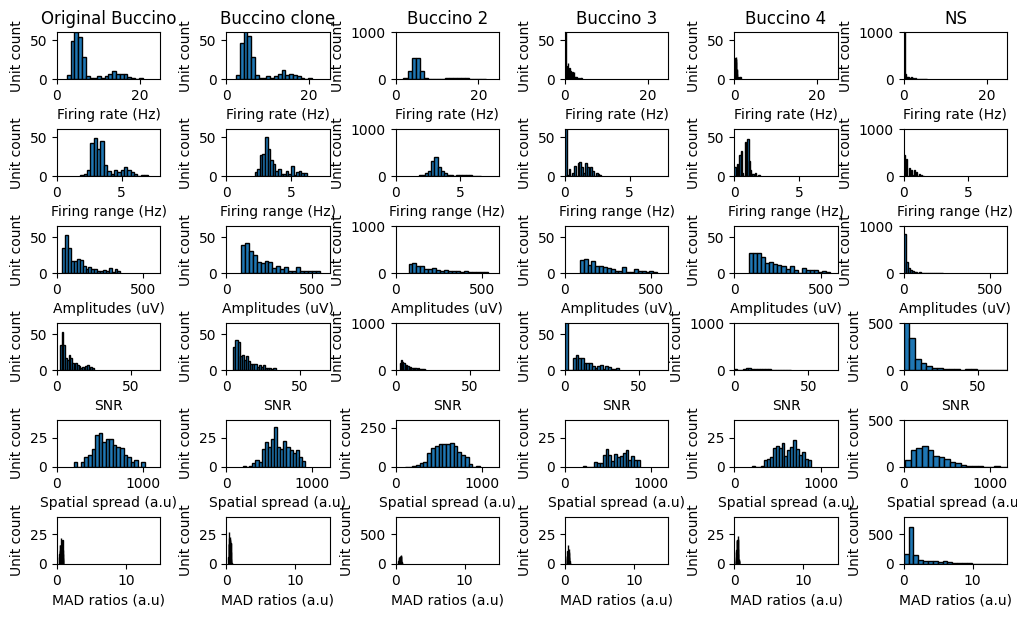

In [16]:
%%time

# setup  plot 
fig, axes = plt.subplots(6,6, figsize=(10,6))

# CELL SPIKING FEATURES ---------------


# firing rates
firing_rates = get_firing_rates(SortingGtBuccino, duration_s=600) # original Buccino
plot_firing_rate_distribution(axes[0,0], firing_rates, title='Original Buccino', ylim=(0,60), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtClone, duration_s=600) # our Buccino clone
plot_firing_rate_distribution(axes[0,1], firing_rates, title='Buccino clone', ylim=(0,60), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtS2, duration_s=600) # our S2
plot_firing_rate_distribution(axes[0,2], firing_rates, title='Buccino 2', ylim=(0,1000), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtS3, duration_s=600) # our S3
plot_firing_rate_distribution(axes[0,3], firing_rates, title='Buccino 3', ylim=(0,60), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtS4, duration_s=600) # our S3
plot_firing_rate_distribution(axes[0,4], firing_rates, title='Buccino 4', ylim=(0,60), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtNS, duration_s=600) # npx_spont
plot_firing_rate_distribution(axes[0,5], firing_rates, title='NS', ylim=(0,1000), xlim=(0,25))


# firing range
firing_ranges = get_firing_ranges(WeGtOriginal)
plot_firing_ranges_distribution(axes[1,0], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtClone)
plot_firing_ranges_distribution(axes[1,1], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtS2)
plot_firing_ranges_distribution(axes[1,2], firing_ranges, title='', ylim=(0,1000), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtS3)
plot_firing_ranges_distribution(axes[1,3], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtS4)
plot_firing_ranges_distribution(axes[1,4], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtNS)
plot_firing_ranges_distribution(axes[1,5], firing_ranges, title='', ylim=(0,1000), xlim=(0,8))


# CELL WAVEFORM FEATURES ---------------

# waveform amplitudes
amplitudes_o = get_waveform_amplitude_medians(WeGtOriginal)
plot_waveform_amplitude_median_distribution(axes[2,0], amplitudes_o, title='', ylim=(0,65), xlim=(0,600))

amplitudes_c = get_waveform_amplitude_medians(WeGtClone)
plot_waveform_amplitude_median_distribution(axes[2,1], amplitudes_c, title='', ylim=(0,65), xlim=(0,600))

amplitudes_c = get_waveform_amplitude_medians(WeGtS2)
plot_waveform_amplitude_median_distribution(axes[2,2], amplitudes_c, title='', ylim=(0,1000), xlim=(0,600))

amplitudes_c = get_waveform_amplitude_medians(WeGtS3)
plot_waveform_amplitude_median_distribution(axes[2,3], amplitudes_c, title='', ylim=(0,65), xlim=(0,600))

amplitudes_c = get_waveform_amplitude_medians(WeGtS4)
plot_waveform_amplitude_median_distribution(axes[2,4], amplitudes_c, title='', ylim=(0,65), xlim=(0,600))

amplitudes_ns = get_waveform_amplitude_medians(WeGtNS)
plot_waveform_amplitude_median_distribution(axes[2,5], amplitudes_ns, title='', ylim=(0,1000), xlim=(0,600))


# signal-to-noise ratio (SNR)
snrs = get_waveform_snr(WeGtOriginal)
plot_waveform_snr_distribution(axes[3,0], snrs, title='', ylim=(0,65), xlim=(0,70))

snrs = get_waveform_snr(WeGtClone)
plot_waveform_snr_distribution(axes[3,1], snrs, title='', ylim=(0,65), xlim=(0,70))

snrs = get_waveform_snr(WeGtS2)
plot_waveform_snr_distribution(axes[3,2], snrs, title='', ylim=(0,1000), xlim=(0,70))

snrs = get_waveform_snr(WeGtS3)
plot_waveform_snr_distribution(axes[3,3], snrs, title='', ylim=(0,65), xlim=(0,70))

snrs = get_waveform_snr(WeGtS4)
plot_waveform_snr_distribution(axes[3,4], snrs, title='', ylim=(0,1000), xlim=(0,70))

snrs = get_waveform_snr(WeGtNS)
plot_waveform_snr_distribution(axes[3,5], snrs[np.isfinite(snrs)], title='', ylim=(0,500), xlim=(0,70))


# spatial spread
spreads = get_spatial_spread_all_units(RECORDING_BUCCINO_PATH, WAVEFORM_GT_BUCCINO_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,0], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_CLONE_PATH, WAVEFORM_GT_CLONE_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,1], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_S2_PATH, WAVEFORM_GT_S2_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,2], spreads, title='', ylim=(0,300), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_S3_PATH, WAVEFORM_GT_S3_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,3], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_S4_PATH, WAVEFORM_GT_S4_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,4], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_NS_PATH, WAVEFORM_GT_NS_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,5], spreads, title='', ylim=(0,500), xlim=(0,1200))


# mad ratio
mad_ratios = get_mad_ratios(WeGtOriginal)
plot_mad_ratio_distribution(axes[5,0], mad_ratios, title='', ylim=(0,40), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtClone)
plot_mad_ratio_distribution(axes[5,1], mad_ratios, title='', ylim=(0,40), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtS2)
plot_mad_ratio_distribution(axes[5,2], mad_ratios, title='', ylim=(0,800), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtS3)
plot_mad_ratio_distribution(axes[5,3], mad_ratios, title='', ylim=(0,40), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtS4)
plot_mad_ratio_distribution(axes[5,4], mad_ratios, title='', ylim=(0,40), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtNS)
plot_mad_ratio_distribution(axes[5,5], mad_ratios, title='', ylim=(0,800), xlim=(0,15))

# CELL POSITIONS -----------------------

# distances to electrode

fig.tight_layout(pad=0.1)

plt.savefig(
    "figures/7_reviews/figxx_pros_of_added_details_1.svg",
    **savefig_cfg,
)

## Yields

In [17]:
SORTED_ks4_paths = {
    "Buccino": 'dataset/01_intermediate/sorting/buccino/SortingKS4',
    's_1\ncopy': './temp/npx_synth_clone/SortingKS4_10m_RTX5090',
    's2\ncell count': './temp/npx_synth2/SortingKS4_10m_RTX5090',
    's3\nrate': './temp/npx_synth3/SortingKS4_10m_RTX5090',
    's4\nrange': './temp/npx_synth4/SortingKS4_10m_RTX5090',
    "NS": SORTING_KS4_NS_PATH,
}

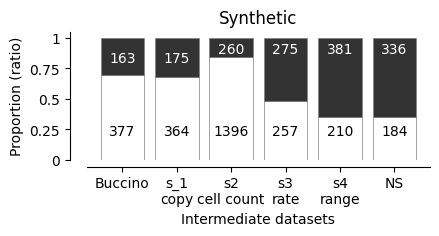

In [18]:
# setup parameters
FIGSIZE = (4.5, 2.5)
SHIFT = 0.3
exp_names = ('Buccino', 's_1\ncopy', 's2\ncell count', 's3\nrate', 's4\nrange', 'NS')
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.2, 'exp1_y_mu': 0.8,
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.2, 'exp2_y_mu': 0.8,
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.2, 'exp3_y_mu': 0.87,
              'exp4_x': 2.7 + SHIFT, 'exp4_y_su': 0.2, 'exp4_y_mu': 0.87,
              'exp5_x': 3.7 + SHIFT, 'exp5_y_su': 0.2, 'exp5_y_mu': 0.87,
              'exp6_x': 4.7 + SHIFT, 'exp6_y_su': 0.2, 'exp6_y_mu': 0.87}
legend_cfg = {"frameon": False, "handletextpad": 0.1}

# compute data
plot_data = process_each_experiment(SORTED_ks4_paths['Buccino'], SORTED_ks4_paths['s_1\ncopy'], 
                                    SORTED_ks4_paths['s2\ncell count'], SORTED_ks4_paths['s3\nrate'], SORTED_ks4_paths['s4\nrange'], 
                                    SORTED_ks4_paths['NS'], exp_names)

# setup plot
_, ax = plt.subplots(1,1,figsize=FIGSIZE)

# plot (white: single-unit; black: multi-units)
isolation.plot_unit_isolation_pros_of_added_detailed(ax, plot_data['Buccino'], 
                                                     plot_data['s_1\ncopy'], plot_data['s2\ncell count'], plot_data['s3\nrate'], 
                                                     plot_data['s4\nrange'], plot_data['NS'], 
                                                     legend_cfg, number_pos, exp_names)

# legend
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
ax.set_title('Synthetic')
plt.tight_layout()

# save figures
plt.savefig(
    "figures/7_reviews/figxx_pros_of_added_details_2.svg",
    **savefig_cfg,
)

- the absolute value matters (the single yield and ratio (optionallym))

- we can test the different spike sorters on these simulations

hyp:
- low cell density -> you might think we need to increase the number of shanks. 
- if we find that we only pick up 10%, it is difficult, we cannot just add more shanks, we need to think of another strategy - density of electfodes ...

Calculate the yield within 50 um for buccino too.

Things we can't do:
- 

In [ ]:
# # check firing rates
# # cell_type = get_cell_type_property_from_mearec(RecGenS3)
# # firing_rates= get_firing_rates(SortingS3, duration_s=600)
# # print(np.array(firing_rates)[cell_type=='E'].mean())
# # print(np.array(firing_rates)[cell_type=='I'].mean())

# firing_ranges = get_firing_ranges(WeGtNS)
# print("\nNS")
# display(firing_ranges.max())
# display(firing_ranges[SortingGtNS.get_property('synapse_class')=='EXC'].std())
# display(firing_ranges[SortingGtNS.get_property('synapse_class')=='INH'].std())

# firing_ranges = get_firing_ranges(WeGtS3)
# print("\nS3")
# display(firing_ranges.max())
# display(firing_ranges[:200].std())
# display(firing_ranges[201:].std())

# firing_ranges = get_firing_ranges(WeGtS4)
# print("\nS4")
# display(firing_ranges.max())
# display(firing_ranges[:200].std())
# display(firing_ranges[201:].std())

# snrs
snrs_s4 = get_waveform_snr(WeGtS4)
print('\n',snrs_s4.min(), snrs_s4.max(), np.median(snrs_s4))

snrs_ns = get_waveform_snr(WeGtNS)
print(np.nanmin(snrs_ns), np.max(snrs_ns[np.isfinite(snrs_ns)]), np.median(snrs_ns[np.isfinite(snrs_ns)]))

# amplitudes
amplitudes_c = get_waveform_amplitude_medians(WeGtS4)
print('\n', np.nanmin(amplitudes_c), np.max(amplitudes_c[np.isfinite(amplitudes_c)]), np.median(amplitudes_c[np.isfinite(amplitudes_c)]))

amplitudes_c = get_waveform_amplitude_medians(WeGtNS)
print(np.nanmin(amplitudes_c), np.max(amplitudes_c[np.isfinite(amplitudes_c)]), np.median(amplitudes_c[np.isfinite(amplitudes_c)]))

# noise_level 10 uV (mad -> 11.53 - ok)
# TODO: make noise level 2.44 instead of 10 uV
# TODO: make amplitude level 2.44 instead of 10 uV
RecordingS4 = si.load_extractor(RECORDING_S4_PATH)
traces = RecordingS4.get_traces()
print('\n', mad(traces[:,0]))

RecordingNS = si.load_extractor(RECORDING_NS_PATH)
traces = RecordingNS.get_traces()
l5 = np.where(RecordingNS.get_property('layers')=='L5')[0]
print(mad(traces[:, l5[0]]))


 0.0 38.075542 11.97565
0.18076326 75.71147 3.8221085

 85.42227 555.2931 178.55473
1.0 227.0 8.0

 11.534774
2.444634


## Clean up

In [ ]:
# clean up default temporary data - you will need to reinstall mearec afterward with pip intall mearec
import shutil

shutil.rmtree(WAVEFORM_GT_BUCCINO_PATH, ignore_errors=True)
shutil.rmtree(WAVEFORM_GT_CLONE_PATH, ignore_errors=True)
shutil.rmtree(WAVEFORM_GT_S2_PATH, ignore_errors=True)
shutil.rmtree(WAVEFORM_GT_S3_PATH, ignore_errors=True)
shutil.rmtree(WAVEFORM_GT_NS_PATH, ignore_errors=True)

# shutil.rmtree(CELLS_PATH, ignore_errors=True)

In [20]:
WeGtNS.get_sorting_property('x')

array([4390.68958743, 4212.211907  , 4371.11370786, ..., 3868.22520407,
       3855.42159682, 4071.21220736])

(array([ 83., 253., 380., 323., 198., 107.,  24.,  12.,   6.,   2.]),
 array([ 1.64889399,  5.89519993, 10.14150586, 14.38781179, 18.63411773,
        22.88042366, 27.12672959, 31.37303553, 35.61934146, 39.86564739,
        44.11195333]),
 <BarContainer object of 10 artists>)

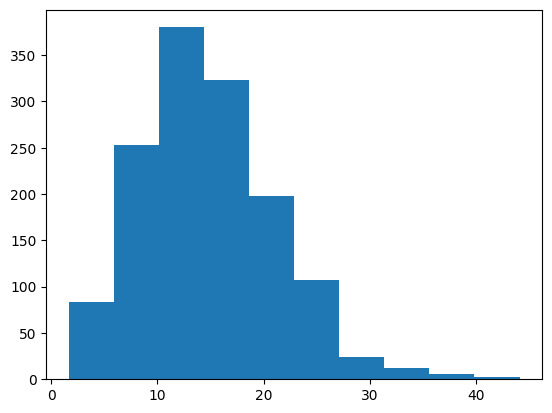

In [30]:
d = get_cell_to_cell_distances(SortingGtNS)
np.fill_diagonal(d, np.nan)
plt.hist(np.nanmin(d, axis=0))

In [ ]:
# strong argument on cell density
#d = get_cell_to_cell_distances(SortingGtBuccino)
loc = SortingGtS2.get_property('soma_location')
d = cdist(loc, loc, metric='euclidean')
np.fill_diagonal(d, np.nan)
plt.hist(np.nanmin(d, axis=0))

# store our cell positions and use them in buccino's simulation to get the exact same cell locations.

# number of single-units should increase by f^3 (upper bound)

# it is important to use biological cell densities, which we use.

ValueError: XA must be a 2-dimensional array.

(array([67., 44., 46., 33., 26., 15.,  4.,  8.,  3.,  4.]),
 array([25.13684631, 29.25511723, 33.37338816, 37.49165908, 41.60993   ,
        45.72820093, 49.84647185, 53.96474277, 58.08301369, 62.20128462,
        66.31955554]),
 <BarContainer object of 10 artists>)

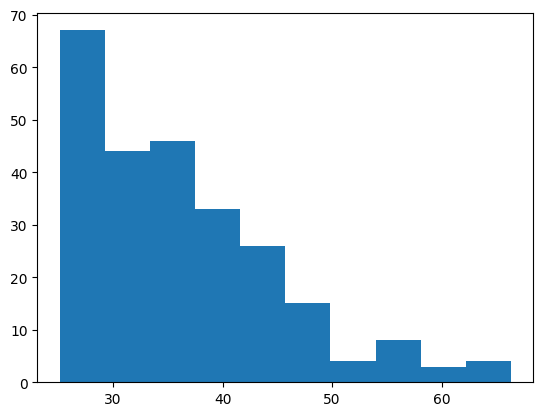

In [ ]:
#d = get_cell_to_cell_distances(SortingGtBuccino)
loc = SortingGtBuccino.get_property('soma_location')
d = cdist(loc, loc, metric='euclidean')
np.fill_diagonal(d, np.nan)
plt.hist(np.nanmin(d, axis=0))

# store our cell positions and use them in buccino's simulation to get the exact same cell locations.

# number of single-units should increase by f^3 (upper bound)

# it is important to use biological cell densities, which we use.

In [ ]:
We match the mean of the distribution 

array([[ 1.84981922e+01, -1.41523918e+00, -1.44294986e+03],
       [ 1.42682544e+01,  5.34390640e+00,  1.62663482e+03],
       [ 1.00421988e+01, -3.32971851e+01, -1.78423700e+03],
       [ 1.07940802e+01,  2.27503683e+01, -1.45500703e+03],
       [ 1.98485852e+01,  1.99896765e+01, -1.37242851e+03],
       [ 3.40256408e+01, -2.30992718e+01, -1.35747635e+03],
       [ 1.77623921e+01,  2.45100009e+01,  1.16298307e+03],
       [ 1.23934200e+01,  7.63347147e+00, -1.12239003e+03],
       [ 1.17296922e+01,  3.56376961e+01,  9.62005382e+02],
       [ 2.80314286e+01, -4.04540050e+01, -1.26769865e+03],
       [ 1.93481574e+01, -3.38809749e+01,  9.43123679e+02],
       [ 2.47519579e+01,  3.14437199e+01, -8.87302799e+02],
       [ 2.14667616e+01,  3.74537529e+00, -7.90217658e+02],
       [ 3.95077076e+01, -3.28122110e+00,  1.07719466e+03],
       [ 1.42413325e+01,  2.45711281e+01,  6.60960175e+02],
       [ 4.96281064e+01, -1.56571559e+01, -9.26272243e+02],
       [ 3.17100142e+01, -3.22061326e+01